# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

In [4]:
#Import packages
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

import matplotlib.pyplot as plt

import cython

from gensim.test.utils import common_texts
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [27]:
# Read data
yelps = pd.read_csv('sentiment/yelps.csv')
len(yelps)

100003

## Technique 1: Logistic Regression using Term-Frequency Matrix

In [25]:
# Pre-process data and fit Logistic Regression model
vectorizer = TfidfVectorizer(min_df=20, 
                             max_df=.6, 
                             use_idf=True, 
                             stop_words='english')


### A: Learn words from full dataset

In [28]:
# Pre-process data - vocabulary will be learned from the full dataset
V = vectorizer.fit_transform(yelps.text)
words_V = vectorizer.get_feature_names()
y = yelps.positive

# Define model
model_LR = LogisticRegression()

# Run model for different versions of train-test split
split = (.01, .02, .03, .04, .05, .1)

scores1 = []
for s in split:
    V_train, V_test, y_train, y_test = train_test_split(V, y, train_size=s, random_state=100)
    model_LR.fit(V_train, y_train)
    y_pred = model_LR.predict(V_test)
    score_LR = model_LR.score(V_test,y_test)
    scores1.append(score_LR)

/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### B: Learn words from training data only

In [29]:
# Vocabulary only learned from the training set
# Pre-process data - vocabulary will be learned from the full dataset
V = yelps.text
y = yelps.positive

# Define model
model_LR = LogisticRegression()

# Run model for different versions of train-test split
split = (.01, .02, .03, .04, .05, .1)

scores2 = []
for s in split:
    V_train, V_test, y_train, y_test = train_test_split(V, y, train_size=s, random_state=100)
    V_train = vectorizer.fit_transform(V_train)
    V_test = vectorizer.transform(V_test)
    model_LR.fit(V_train, y_train)
    y_pred = model_LR.predict(V_test)
    score_LR = model_LR.score(V_test,y_test)
    scores2.append(score_LR)

/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

## Technique 2: Word2Vec

In [6]:
def data_prep(docs):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    documents = []
    # Prepare data
    for d in docs:
        document = d.lower()
        document = re.sub("[.,?]","", document)
        document = re.sub('"', "", document)
        document = document.split()
        document = [word for word in document if word not in stop_words]
        document = [lemmatizer.lemmatize(word) for word in document]
        documents.append(document)
    return(documents)

In [7]:
# preprocess documents
docs = data_prep(yelps.text)

In [41]:
# create word to vec word list
#w2v = Word2Vec(docs, size=100, min_count=1, workers=4)
#w2v2 = Word2Vec(docs, size=100, min_count=1, sg = 1, workers=4)
w2v3 = Word2Vec(docs, size=100, min_count=1, window = 8, workers=4)

In [42]:
wordlist = w2v3.wv
# use the word to vec word list to embed the documents
def embed_words(docs):
    embedded = []
    for doc in docs:
        d = np.zeros((len(doc),100), dtype = float)
        for idx, word in enumerate(doc):
            try:
                d[idx] = wordlist[word]
            except Exception:
                d[idx] = .01
        d_flat = np.average(d, axis = 0)
        embedded.append(d_flat)
        
    #identify and remove NaNs
    indices = []
    for idx,v in enumerate(embedded):
        array_sum = np.sum(v)
        array_has_nan = np.isnan(array_sum)
        if array_has_nan == True:
            indices.append(idx)
    docs_embedded = np.delete(embedded, indices, axis = 0)
    return(docs_embedded, indices)

In [43]:
# Embed words
V, indices = embed_words(docs)

# Remove y's corresponding to NaN values in V
# y = yelps.positive
# for i in indices:
#     del y[i]
# len(y)

/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [47]:
# Define model
model_LR = LogisticRegression()

# Run model for different versions of train-test split
split = (.01, .02, .03, .04, .05, .1)

scores5 = []
for s in split:
    print(s)
    V_train, V_test, y_train, y_test = train_test_split(V, y, train_size=s, random_state=100)
    model_LR.fit(V_train, y_train)
    y_pred = model_LR.predict(V_test)
    score_LR = model_LR.score(V_test,y_test)
    scores5.append(score_LR)

0.01


/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.02
0.03


/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.04
0.05


/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.1


/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/kristin.lomicka/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [49]:
scores5

[0.9304848484848485,
 0.9344897959183673,
 0.9367628865979382,
 0.9383958333333333,
 0.9404210526315789,
 0.9415777777777777]

## Plot Results

Text(0.5, 0, '% training data')

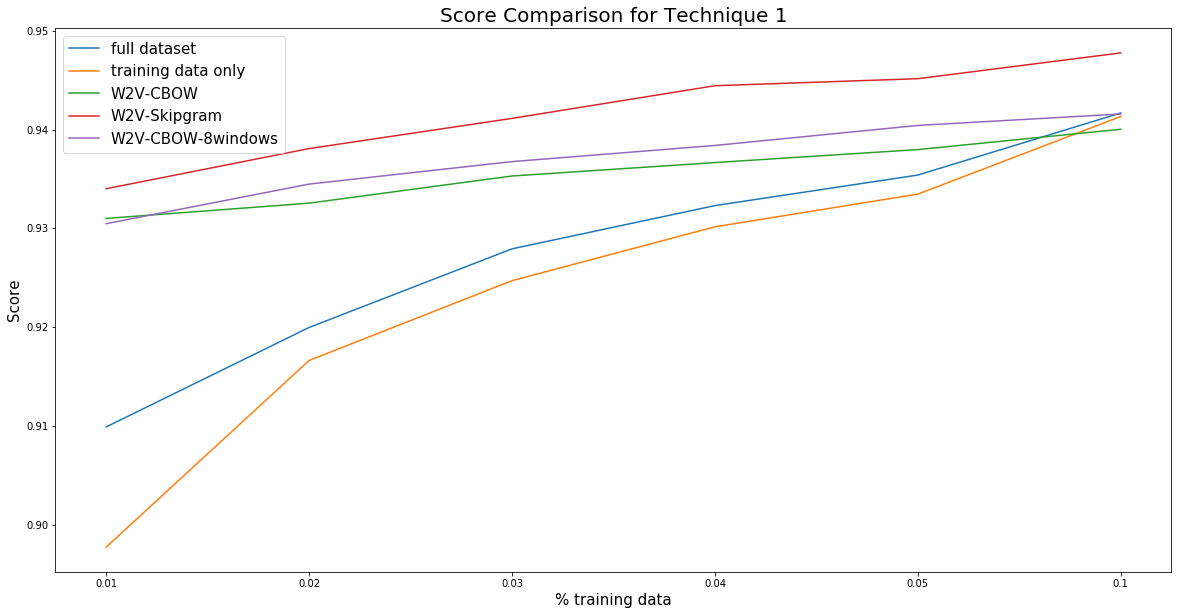

In [51]:
plt.figure(figsize = (20,10))
labels = ('full dataset', 'training data only', 'W2V-CBOW', 'W2V-Skipgram', 'W2V-CBOW-8windows' )
plt.title("Score Comparison for Technique 1", fontsize = 20)
split = (.01, .02, .03, .04, .05, .1)
plt.xticks(ticks = (0,1, 2, 3, 4, 5), labels = split)
plt.plot(scores1)
plt.plot(scores2)
plt.plot(scores3)
plt.plot(scores4)
plt.plot(scores5)
plt.legend(labels, fontsize = 15)
plt.ylabel("Score", fontsize = 15)
plt.xlabel("% training data", fontsize = 15)

**Assessment:** The best performing model was Word2Vec - Skipgram model with the word embeddings trained on the full dataset. In general, the Word2Vec models outperformed the TfidfVectorizer models. In addition, models where the embeddings were created off the full dataset outperformed models using only the training data. 